# MoLE training

Multifile dataset augmentation and loading

In [1]:
import os
import random

from tqdm.notebook import tqdm

In [2]:
device='cuda'
def generate_response (text_input="Biology offers amazing",
                      num_return_sequences=1,
                      temperature=1., #the higher the temperature, the more creative the model becomes
                      max_new_tokens=127,
                      num_beams=1,
                      top_k = 50,
                      top_p =0.9,repetition_penalty=1.,eos_token_id=2,verbatim=False,
                      exponential_decay_length_penalty_fac=None,
                      ):

    inputs = tokenizer.encode(text_input,  
                              add_special_tokens  =False,  
                              return_tensors ='pt')
    if verbatim:
        print ("Length of input, tokenized: ", inputs.shape, inputs)
    with torch.no_grad():
          outputs = model.generate(input_ids=inputs.to(device), 
                                   max_new_tokens=max_new_tokens,
                                   temperature=temperature, #value used to modulate the next token probabilities.
                                   num_beams=num_beams,
                                   top_k = top_k,
                                   top_p =top_p,
                                   num_return_sequences = num_return_sequences, eos_token_id=eos_token_id,
                                   do_sample =True,#skip_prompt=True,
                                   # exponential_decay_length_penalty = [inputs.shape[1], 
                                   #                                     exponential_decay_length_penalty_fac],
                                   # length_penalty =   exponential_decay_length_penalty_fac,
                                    
                    repetition_penalty=repetition_penalty,
                                   #repetition_penalty_range = 2048,
                                    #    repetition_penalty_slope = 0,
                                  )
    return tokenizer.batch_decode(outputs[:,inputs.shape[1]:].detach().cpu().numpy(), skip_special_tokens=True)

In [3]:
on_Lambda = False #True

if on_Lambda:
    !python3 -m pip install --upgrade pip
    
    !pip install -U trl git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/accelerate.git git+https://github.com/huggingface/peft.git
    !pip install -U datasets einops wandb unidecode protobuf==3.20.0 bitsandbytes 
    !pip install -U trl
    !pip install -U scipy
    !pip install -U matplotlib
    
else:
    #os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    os.environ['HUGGINGFACE_HUB_CACHE '] = "/mnt/d/.cache_Huggingface/"
    os.environ['HF_HOME'] = "/mnt/d/.cache_Huggingface/"


In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import transformers
from datasets import load_dataset
from datasets import IterableDataset

from transformers import Trainer
from transformers import TrainingArguments
from transformers import DataCollatorWithPadding
from transformers import TrainerCallback
from transformers import AutoConfig
from transformers import BitsAndBytesConfig

from peft import LoraConfig, get_peft_model
from torch.utils.data import Dataset
from transformers import get_linear_schedule_with_warmup

import math
import numpy as np
import unidecode
import pandas as pd
from matplotlib import pyplot as plt

In [6]:
torch.version.cuda, torch.__version__, torch.backends.cudnn.version(), torch.backends.cudnn.enabled, torch.cuda.is_available()

('12.2', '2.0.1', 8902, True, True)

In [7]:
torch.cuda.get_device_name(), torch.cuda.device_count()

('NVIDIA A10', 1)

In [8]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA A10


In [9]:
device = torch.device("cuda")

In [9]:
token = 'hf_xxxxxxxxxxxxxxxxxxxxxxxxx'
from huggingface_hub import login
login(token=token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /mnt/d/.cache_Huggingface/token
Login successful


### Parameters

In [10]:
epochs = 5
learning_rate = 1e-4
#warmup_steps = 1e2
epsilon = 1e-8
batch_size=1 
train_test_split = 1 #80% of the FILES
gradient_accumulation_steps=4

output_dir = 'Mistral_v200Zephyr'
FT_model_name = 'Mistral_v200Zephyr' #BioLlama_7b_4bit_190_withend
loss_file='Mistral_v200Zephyr.csv'

In [11]:
def params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])

    print("Parameters: ", params) 

In [12]:
#del model

In [13]:
from accelerate import infer_auto_device_map

In [15]:
model_name= 'HuggingFaceH4/zephyr-7b-beta'

bnb_config4bit = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    #bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_compute_dtype=torch.bfloat16,
    use_nested_quant = False,
)

bnb_config8bit = BitsAndBytesConfig(
    load_in_8bit=True,
    #bnb_8bit_compute_dtype=torch.bfloat16,
    bnb_8bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    #quantization_config= bnb_config8bit, 
    #quantization_config= bnb_config4bit, #bnb_config,
    trust_remote_code=True,
    #load_in_8bit=True, 
    device_map="auto",
    torch_dtype=  torch.bfloat16,
   # use_flash_attention_2=True,
    #device_map="cuda:0",
)#.to (device)
model.config.use_cache = False


config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [17]:
model_name= 'HuggingFaceH4/zephyr-7b-beta'
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True,
                                         #device_map="cuda:0",
                                          device_map="auto",
                                         )
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training
tokenizer.add_bos_token, tokenizer.add_eos_token
#tokenizer.padding_side = "left" # Fix weird overflow issue with fp16 training
eos_token= tokenizer.eos_token_id

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [18]:
tokenizer.pad_token

'</s>'

In [19]:
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot who always responds in the style of a pirate",
    },
    {"role": "user", "content": "How many helicopters can a human eat in one sitting?"},
    {"role": "assistant", "content": "Sample response."},
]
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
prompt

'<|system|>\nYou are a friendly chatbot who always responds in the style of a pirate</s>\n<|user|>\nHow many helicopters can a human eat in one sitting?</s>\n<|assistant|>\nSample response.</s>\n<|assistant|>\n'

In [20]:
pwd

'/home/ubuntu/mole'

### Set up LoRA model (adaptors)

In [22]:

from transformers import AutoModelForCausalLM, AutoConfig
import mole
 
from importlib import reload

mole=reload(mole)

config = AutoConfig.from_pretrained(model_name)
model = mole.add_mole_to_model(model = model,
                              
                       mole_config = mole.MoLEConfig(config.hidden_size, mole_depth=2,
                                pad_token_id=tokenizer.pad_token_id),
                     verbose=True,
                       adapters = {"adapter_1": "./mole-checkpoints/checkpoint-a", 
                                   "adapter_2": "./mole-checkpoints/checkpoint-a",
                                  })


100%|██████████| 2376/2376 [00:00<00:00, 738580.47it/s]

Swapped 160 layers.


In [23]:
params (model)

Parameters:  0


In [24]:
model.print_trainable_parameters()

trainable params: 131,136 || all params: 14,575,870,016 || trainable%: 0.0009


In [25]:
model

MoLEModel(
  (model): PeftMixedModel(
    (base_model): MixedModel(
      (model): MistralForCausalLM(
        (model): MistralModel(
          (embed_tokens): Embedding(32000, 4096, padding_idx=2)
          (layers): ModuleList(
            (0-31): 32 x MistralDecoderLayer(
              (self_attn): MistralAttention(
                (q_proj): lora.Linear(
                  (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                  (lora_dropout): ModuleDict(
                    (adapter_1): Dropout(p=0.05, inplace=False)
                    (adapter_2): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (adapter_1): Linear(in_features=4096, out_features=16, bias=False)
                    (adapter_2): Linear(in_features=4096, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (adapter_1): Linear(in_features=16, out_features=4096, bias=Fals

In [ ]:
model, model.print_trainable_parameters()

In [27]:
print (dir(mole))

['MoLEConfig', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'add_mole_to_model', 'from_pretrained', 'mole', 'mole_classifier', 'mole_config', 'mole_insertion_layers', 'mole_model', 'mole_state', 'set_scalings_with_lifetime']


In [28]:
tokenizer.add_bos_token=True #False

In [31]:
import pandas as pd
  
fname='./BioMat_ExaminationsQ_UPDATED.csv'
df_trial=pd.read_csv(fname)
df_trial

eos_token=tokenizer.eos_token_id

def trial(df_trial, step_number=0, frac=1. ):

    questions=[]
    answers=[]
    corr_answers=[]

    if frac<1:
        df_trial=df_trial.sample (frac=frac, random_state=42).reset_index()
    
    for q,CorrectA in tqdm(zip(df_trial['Question'],df_trial['Answer'])):    
        print ("###########################################################################")
        #q=f'Select only one option as the correct answer (A,  B, or C): "{q.strip()}"'
        #q=f'{q.strip()}'
        
        #txt=f"<s>### System:\n{system_prompt}\n\n### User:\n{q}\n\n### Assistant:\n{prepend_response}" 
        
        #txt=system_prompt+f"Select only one option as the correct answer (A,  B, or C): " + q + "[/INST]"
        #txt=f"[INST] {q} [/INST]"
        #txt=f"<s>{system_prompt} [INST] Select only one option as the correct answer (A,  B, or C): " + q + "[/INST]"
        #txt=f"<s>[INST] Select only one option as the correct answer (A,  B, or C): " + q + "[/INST]"
        #txt=f"<s>Select the correct answer</s><s>. [INST] " + q + "[/INST]"
        #txt=f"<s>You are an expert in biological and bio-inspired materials. [INST] Select only one option as the correct answer (A,  B, or C): " + q + ". Very brief answer. [/INST]"
        txt=f"<s><|user|>\nSelect only one option as the correct answer (A,  B, or C): " + q.strip() + "</s>\n<|assistant|>\n"

        #'<|system|>\nYou are a friendly chatbot who always responds in the style of a pirate</s>\n<|user|>\nHow many helicopters 
        #can a human eat in one sitting?</s>\n<|assistant|>\n

        
        #txt=f"<s>You are an expert in biological and bio-inspired materials. [INST] Read this question: "+ q + "Select only one option as the correct answer (A,  B, or C): " + q + "[/INST]"
        #txt=f"<s> Select only one option as the correct answer (A,  B, or C): " + q  
        #print (f"QUESTION: {txt}")
        #txt=f"<s>{q}"
        #txt=f"<s>### User:\n{q}\n\n### Assistant:\n{prepend_response}" 
        #print (txt) 
        #result=generate_response ("[INST] Select only one option as the correct answer (A,  B, or C): " + csv_data_list[l] + "[/INST]",repetition_penalty = 1.1, \
        #temperature=.1,max_new_tokens=100,num_return_sequences=5) 
    
        
        output_text=generate_response (text_input=txt,eos_token_id=eos_token,
                              num_return_sequences=1,  repetition_penalty=1.,
                                       # top_p=0.95, top_k=500, 
                                       top_p=0.9, top_k=50,  
                             #temperature=.1,max_new_tokens=100, verbatim=True, 
                             temperature=.1,max_new_tokens=256, verbatim=False, 
                                        
                                       )
      
        
        #print("\nANSWER: ", output_text[0],'\n')
        print (f"Question: {q}\nAnswer: {output_text[0]}\nCorrect answer={CorrectA}")
        questions.append (q)
        answers.append (output_text[0])
        corr_answers.append (CorrectA)

    
    df_res = pd.DataFrame({"text": questions, "answers": answers, "corr_answers": corr_answers} )
    df_res.to_csv(f'./{output_dir}/out_{FT_model_name}_{step_number}.csv')

    return df_res


In [32]:
eos_token

2

### Data loader and related functions 

  0%|          | 0/22283 [00:00<?, ?it/s]

Max tokenized: 1608, max length (words): 803


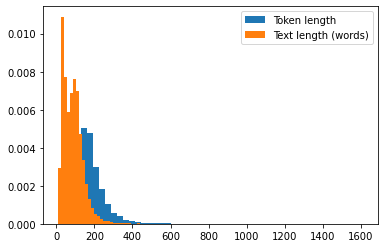

In [37]:
### ALTERNATIVE DATALOADER

    
#start_token = '<s>'
#end_token = '</s>'
#sys_token = '<<SYS>>'
#or_start_token = '[INST]'
#or_end_token = '[/INST]' 

pad_all=False #then padding happens in data collector 

# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, text_list):
        #self.titles = df['Article Title']
        #self.abstracts = df['Abstract']
        self.textlist=text_list

    def __getitem__(self, idx):
         
        #line =  f"{inst_start_token} {self.titles[idx]} {inst_end_token} {self.abstracts[i]} {end_token}"
        line =  self.textlist[idx]
        #print (line[:16])
        #print (f'{idx}-', end='')
        
        if text_only:
            out = {
                   "text": line
                  }
        
        elif pad_all:
            res = tokenizer(line, truncation=True, max_length=MAX_TOKENIZED_LENGTH, 
                                    padding="max_length",
                                    return_tensors="pt",
                                   
                                   )

            out = {
                   "input_ids": res["input_ids"].squeeze(), "attention_mask":res["attention_mask"].squeeze(),
                   "labels": res["input_ids"].clone().detach().squeeze()#,
                   #"text": line
                  }
        
        else:
            res = tokenizer(line, #truncation=True, max_length=MAX_TOKENIZED_LENGTH, 
                                   # padding="max_length",
                                    return_tensors="pt",
                                   
                                   )
    
            out = {
                   "input_ids": res["input_ids"].squeeze(), "attention_mask":res["attention_mask"].squeeze(),
                   "labels": res["input_ids"].clone().detach().squeeze()#,
                   #"labels": res["input_ids"].clone().detach().squeeze(),
                   #"text": line
                  }
        
        #print (item)
        return out

    def __len__(self):
        return len(self.textlist)



max_leng_critical=1800
max_len=-1
max_len_txt=-1
len_list=[]
len_list_txt=[]
text_list=[]

use13b=True
Orca_include=True
Orca_singleout_include=True
#numerical_include=False
numerical_include=True

use13b=False
Orca_include=False
Orca_singleout_include=False
#numerical_include=False
numerical_include=False

CoT_include=False #True

Q_A_include=True
format_qa=True #whether to use chat template 

if Q_A_include:
    
    data=pd.read_csv('train_data_processed_Mistral_train_data_small_COMBINED.csv_0_FINAL.csv')
    
    for idx in tqdm ( range (len (data['question'])) ):
        
        #system_prompt='You are BioinspiredLLM, a helpful assistant.'
        
        if format_qa:

            messages = [
             
            {"role": "user", "content": data['question'][idx]},
            {"role": "assistant", "content": data['answer'][idx]},
            
            ]
            line = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)

        else:
            line=f"{data['question'][idx]} {data['answer'][idx]}</s>" 



        
        tok=tokenizer(line,  return_tensors="pt",  )
    
        if tok['input_ids'].shape[1]<max_leng_critical:
            
            if tok['input_ids'].shape[1]>=max_len:
                max_len=tok['input_ids'].shape[1]
        
                
                #print (len (line.split ()))
            if len (line.split ())>max_len_txt:
                max_len_txt=len (line.split ())
        
            len_list.append (tok['input_ids'].shape[1])
            len_list_txt.append (len (line.split ()))
        
            text_list.append (line)



if CoT_include:
    max_leng_critical_CoT=1000
    
    data=pd.read_csv('ALLDATASETS/13b_train_data_smallv2_processed_llama_B_MERGED.csv')

    dataset = load_dataset('json', data_files="./CoT_data.json", )


    for item in tqdm (dataset["train"]):
        
        messages = [
         
        {"role": "user", "content": item['instruction']},
        {"role": "assistant", "content": item['output']},
        
        ]
        line = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
    
        tok=tokenizer(line,  return_tensors="pt",  )
    
        if tok['input_ids'].shape[1]<max_leng_critical_CoT:
            
            if tok['input_ids'].shape[1]>=max_len:
                max_len=tok['input_ids'].shape[1]
        
                
                #print (len (line.split ()))
            if len (line.split ())>max_len_txt:
                max_len_txt=len (line.split ())
        
            len_list.append (tok['input_ids'].shape[1])
            len_list_txt.append (len (line.split ()))
        
            text_list.append (line)


if use13b:
    
    data=pd.read_csv('../ALLDATASETS/13b_train_data_smallv2_processed_llama_B_MERGED.csv')
    
    for idx in tqdm ( range (len (data['question'])) ):
        '''
        <s>[INST] <<SYS>>
        You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
        
        If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
        <</SYS>>
        
        There's a llama in my garden 😱 What should I do? [/INST]
        '''
        system_prompt='You are BioinspiredLLM, a helpful assistant.'
        ########################################################
        #line=f"{CNT['text'][idx]}{end_token}"
        #line=f"{or_start_token} {CNT['question'][idx]} {or_end_token} {CNT['answer'][idx]} {end_token}" 
        #line=f"<|user|>\n{data['question'][idx]}</s>\n<|assistant|>\n{data['answer'][idx]}</s>" 
        line=f"{data['question'][idx]} {data['answer'][idx]}</s>" 
        #prompt =  f"<|im_start|>system\n{system_prompt}<|im_end|>\n<|im_start|>user\n{user_message}<|im_end|>\n<|im_start|>assistant"
    
    
    
        #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
        #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
    
        #line=f"{data['question'][idx]} {data['answer'][idx]}" 
        tok=tokenizer(line,  return_tensors="pt",  )
    
        if tok['input_ids'].shape[1]<max_leng_critical:
            
            if tok['input_ids'].shape[1]>=max_len:
                max_len=tok['input_ids'].shape[1]
        
                
                #print (len (line.split ()))
            if len (line.split ())>max_len_txt:
                max_len_txt=len (line.split ())
        
            len_list.append (tok['input_ids'].shape[1])
            len_list_txt.append (len (line.split ()))
        
            text_list.append (line)


if Orca_singleout_include:
    fname='ALLDATASETS/train_data_processed_OpenOrca_singleoutput_train_data_chunked_text.csv_0_Lambda_0_FINAL.csv'
    data=pd.read_csv(fname)
    #data.head ()
    for idx in tqdm ( range (len (data['title'])) ):
        '''
        <s>[INST] <<SYS>>
        You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
        
        If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
        <</SYS>>
        
        There's a llama in my garden 😱 What should I do? [/INST]
        '''
        system_prompt='You are BioinspiredLLM, a helpful assistant.'
        ########################################################
        #line=f"{CNT['text'][idx]}{end_token}"
        #line=f"{or_start_token} {CNT['question'][idx]} {or_end_token} {CNT['answer'][idx]} {end_token}" 
        #line=f"<|user|>\n{data['question'][idx]}</s>\n<|assistant|>\n{data['answer'][idx]}</s>" 
        #line=f"{data['title'][idx]} {data['summary'][idx]} {data['key_fact'][idx]}</s>" 
        line=f"{data['summary'][idx]}</s>" 
        #prompt =  f"<|im_start|>system\n{system_prompt}<|im_end|>\n<|im_start|>user\n{user_message}<|im_end|>\n<|im_start|>assistant"
    
    
    
        #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
        #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
    
        #line=f"{data['question'][idx]} {data['answer'][idx]}" 
        tok=tokenizer(line,  return_tensors="pt",  )
    
        if tok['input_ids'].shape[1]<max_leng_critical:
            
            if tok['input_ids'].shape[1]>=max_len:
                max_len=tok['input_ids'].shape[1]
        
                
                #print (len (line.split ()))
            if len (line.split ())>max_len_txt:
                max_len_txt=len (line.split ())
        
            len_list.append (tok['input_ids'].shape[1])
            len_list_txt.append (len (line.split ()))
        
            text_list.append (line)
    print (f"Max tokenized: {max_len}, max length (words): {max_len_txt}")
    MAX_TOKENIZED_LENGTH=max_len
    
    
if Orca_include:
    data=pd.read_csv('ALLDATASETS/train_data_processed_OpenOrca_shorter_train_data_chunked_text.csv_0_Lambda_0_FINAL.csv')
    #data.head ()
    for idx in tqdm ( range (len (data['title'])) ):
        '''
        <s>[INST] <<SYS>>
        You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
        
        If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
        <</SYS>>
        
        There's a llama in my garden 😱 What should I do? [/INST]
        '''
        system_prompt='You are BioinspiredLLM, a helpful assistant.'
        ########################################################
        #line=f"{CNT['text'][idx]}{end_token}"
        #line=f"{or_start_token} {CNT['question'][idx]} {or_end_token} {CNT['answer'][idx]} {end_token}" 
        #line=f"<|user|>\n{data['question'][idx]}</s>\n<|assistant|>\n{data['answer'][idx]}</s>" 
        line=f"{data['title'][idx]} {data['summary'][idx]} {data['key_fact'][idx]}</s>" 
        #prompt =  f"<|im_start|>system\n{system_prompt}<|im_end|>\n<|im_start|>user\n{user_message}<|im_end|>\n<|im_start|>assistant"
    
    
    
        #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
        #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
    
        #line=f"{data['question'][idx]} {data['answer'][idx]}" 
        tok=tokenizer(line,  return_tensors="pt",  )
    
        if tok['input_ids'].shape[1]<max_leng_critical:
            
            if tok['input_ids'].shape[1]>=max_len:
                max_len=tok['input_ids'].shape[1]
        
                
                #print (len (line.split ()))
            if len (line.split ())>max_len_txt:
                max_len_txt=len (line.split ())
        
            len_list.append (tok['input_ids'].shape[1])
            len_list_txt.append (len (line.split ()))
        
            text_list.append (line)
    print (f"Max tokenized: {max_len}, max length (words): {max_len_txt}")
    MAX_TOKENIZED_LENGTH=max_len
    


if numerical_include:
    
    data=pd.read_csv('ALLDATASETS/train_data_processed_GPT35-numerical_train_data_chunked_text-COMBINED.csv')
    #data.head ()
    for idx in tqdm ( range (len (data['title'])) ):
        '''
        <s>[INST] <<SYS>>
        You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
        
        If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
        <</SYS>>
        
        There's a llama in my garden 😱 What should I do? [/INST]
        '''
        system_prompt='You are BioinspiredLLM, a helpful assistant.'
        ########################################################
        #line=f"{CNT['text'][idx]}{end_token}"
        #line=f"{or_start_token} {CNT['question'][idx]} {or_end_token} {CNT['answer'][idx]} {end_token}" 
        #line=f"<|user|>\n{data['question'][idx]}</s>\n<|assistant|>\n{data['answer'][idx]}</s>" 
        
        if data['summary'][idx] != '':
            line=f"{data['summary'][idx]}</s>" 
            #prompt =  f"<|im_start|>system\n{system_prompt}<|im_end|>\n<|im_start|>user\n{user_message}<|im_end|>\n<|im_start|>assistant"
        
        
        
            #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
            #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
        
            #line=f"{data['question'][idx]} {data['answer'][idx]}" 
            tok=tokenizer(line,  return_tensors="pt",  )
        
            if tok['input_ids'].shape[1]<max_leng_critical:
                
                if tok['input_ids'].shape[1]>=max_len:
                    max_len=tok['input_ids'].shape[1]
            
                    
                    #print (len (line.split ()))
                if len (line.split ())>max_len_txt:
                    max_len_txt=len (line.split ())
            
                len_list.append (tok['input_ids'].shape[1])
                len_list_txt.append (len (line.split ()))
            
                text_list.append (line)
    
    
    
    data=pd.read_csv('ALLDATASETS/train_data_processed_GPT35-numerical_train_data_chunked_text_v3_REPEAT.csv')
    #data.head ()
    for idx in tqdm ( range (len (data['title'])) ):
        '''
        <s>[INST] <<SYS>>
        You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
        
        If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
        <</SYS>>
        
        There's a llama in my garden 😱 What should I do? [/INST]
        '''
        system_prompt='You are BioinspiredLLM, a helpful assistant.'
        ########################################################
        #line=f"{CNT['text'][idx]}{end_token}"
        #line=f"{or_start_token} {CNT['question'][idx]} {or_end_token} {CNT['answer'][idx]} {end_token}" 
        #line=f"<|user|>\n{data['question'][idx]}</s>\n<|assistant|>\n{data['answer'][idx]}</s>" 
        
        if data['summary'][idx] != '':
            line=f"{data['summary'][idx]}</s>" 
            #prompt =  f"<|im_start|>system\n{system_prompt}<|im_end|>\n<|im_start|>user\n{user_message}<|im_end|>\n<|im_start|>assistant"
        
        
        
            #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
            #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
        
            #line=f"{data['question'][idx]} {data['answer'][idx]}" 
            tok=tokenizer(line,  return_tensors="pt",  )
        
            if tok['input_ids'].shape[1]<max_leng_critical:
                
                if tok['input_ids'].shape[1]>=max_len:
                    max_len=tok['input_ids'].shape[1]
            
                    
                    #print (len (line.split ()))
                if len (line.split ())>max_len_txt:
                    max_len_txt=len (line.split ())
            
                len_list.append (tok['input_ids'].shape[1])
                len_list_txt.append (len (line.split ()))
            
                text_list.append (line)
print (f"Max tokenized: {max_len}, max length (words): {max_len_txt}")
MAX_TOKENIZED_LENGTH=max_len

import random

 
# Shuffle the list
random.shuffle(text_list)

text_only=False #True
#text_only=True #True

if text_only:
    import datasets 
    df_out = pd.DataFrame({"text": text_list,})
    train_dataset = datasets.Dataset.from_pandas(df_out)
    
else:
    train_dataset = Dataset(text_list )



n_fragments=len (text_list)
len (train_dataset), isinstance(train_dataset, torch.utils.data.Dataset)
#MAX_TOKENIZED_LENGTH=768

plt.hist (len_list, label = 'Token length', density=True, bins=50)
plt.hist (len_list_txt, label = 'Text length (words)', density=True, bins=50)
plt.legend ()
plt.savefig ('dist.svg')
plt.show()

In [38]:
max_len

1608

In [39]:
MAX_TOKENIZED_LENGTH

1608

In [40]:
text_list[:6]

["<|user|>\n What is the concept of material indices in bending?</s>\n<|assistant|>\n Material indices in bending are used to characterize the efficiency of a microstructured material in a given loading mode. They are dimensionless numbers that depend on the material properties and geometry of the beam. The two most commonly used material indices are ph and M1, which are defined as follows:\n\n* ph: The dimensionless shape factor, which is the ratio of the bending modulus of the cellular material to the bending modulus of the solid material. It ranges from 0 to 2 and characterizes the efficiency of the material in bending.\n* M1: The material index M1 is defined as the ratio of the Young's modulus of the cellular material to the Young's modulus of the solid material, divided by the material density. It is a dimensionless number that ranges from 0 to 1 and is used to compare the mechanical properties of different materials in bending.\n\nThese material indices can be used to predict the

In [41]:
MAX_TOKENIZED_LENGTH

1608

In [42]:
iterator=iter (train_dataset)
for i in range (4):# (len (train_dataset)):
    #print (next (iterator)['text'] )
    print (next (iterator)['input_ids'].shape )
    print (next (iterator)['input_ids'] )
    #print (next (iterator)['text'])

torch.Size([256])
tensor([    1,   523, 28766,  1838, 28766, 28767,    13, 28705, 28740, 28723,
         1824,   349,   272,  4803, 20095, 13735,   302,   367,  1251, 28737,
        28769, 28748, 28743, 28733, 28754, 11628, 28818,  7903,   668,   266,
          490,   916, 12734, 25242,   477,  1741,   298,  2475,   340,  1517,
        28804,     2, 28705,    13, 28789, 28766,   489, 11143, 28766, 28767,
           13,   415,  4803, 20095, 13735,   302,   367,  1251, 28737, 28769,
        28748, 28743, 28733, 28754, 11628, 28818,  7903,   668,   266,   490,
          916, 12734, 25242,   477,  1741,   298,  2475,   340,  1517,   349,
         4894,   297, 28705, 28750, 28781, 28706, 28733,  9977, 28733,  2559,
        28723,     2, 28705,    13])
torch.Size([265])
tensor([    1,   523, 28766,  1838, 28766, 28767,    13, 22478, 28747,  1824,
          460,   272, 21549,  8429,   302, 17004, 28733,  2628,   282, 22154,
          886,   370, 23693,   300,  2471, 28713, 28804,     2, 28705

In [43]:
tokenizer.pad_token_id

2

In [44]:
#keep norm layers in high accuracy 
#for name, module in model.named_modules():
#    if "norm" in name:
#        module = module.to(torch.float16)

In [45]:
batch_size

1

In [46]:
epochs=5

### Set up training parameters, and train 

In [47]:
total_steps =  int (epochs*  (int (n_fragments*train_test_split )//batch_size )/gradient_accumulation_steps)
steps_per_epoch=total_steps//epochs

In [48]:
warmup_ratio=0.01
warmupsteps=int (total_steps*0.01)

In [49]:
total_steps, steps_per_epoch, warmupsteps

(27811, 5562, 278)

In [39]:
class push_callback(TrainerCallback):
    def on_save(self, args, state, control, **kwargs):

        try:
            print ("Step: Pushing model...", state.global_step )
            model.push_to_hub(FT_model_name, private=True)  
            
        except:
            print ("Push error...", state.global_step )
        #tokenizer.push_to_hub(FT_model_name, private=True)  

        #try:
        #    model.save_pretrained (output_dir+"/checkpoint")

        try:
            df=pd.DataFrame(trainer.state.log_history)
            df.to_csv(output_dir+loss_file)
    
            plt.plot (df['step'], df['loss'], 'o-', label = 'Training loss', )
            plt.legend ()
            plt.ylabel ('Loss')
            plt.xlabel  ('Step')
            plt.savefig(output_dir+f'/loss_{state.global_step}.svg')
            plt.show()
        except:
            print ("Plotting failed.")

        try:
            #result=generate_response (text_input=f"{start_token}[INST]To create a tough and strong soft material using a biomimetic collagen design, what do I do? [/INST]",num_return_sequences=1,
            #                         temperature=.5,max_new_tokens=128)

            #trial ()
            df_res=trial (df_trial,step_number=state.global_step, frac= 1)
            
            
        except:
            print ("Trial generation failed.")
        

In [50]:
df_res=trial (df_trial,step_number=223, frac= 1)

0it [00:00, ?it/s]

###########################################################################


RecursionError: maximum recursion depth exceeded while calling a Python object

In [53]:
from transformers import TrainingArguments

output_dir = output_dir
per_device_train_batch_size = batch_size
gradient_accumulation_steps = gradient_accumulation_steps
#optim = "paged_adamw_32bit"
optim = "paged_adamw_8bit"
save_steps = steps_per_epoch
logging_steps = steps_per_epoch
learning_rate = learning_rate
max_grad_norm = 0.3
max_steps = total_steps
 
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    #fp16=True,
    bf16=True, #on A100
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    #group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    save_total_limit=50,
    report_to= "none", #change if you want to use wandb
)

In [54]:
 FT_model_name

'Mistral_v200Zephyr'

In [43]:
train_dataset[0]

{'input_ids': tensor([    1,   523, 28766,  1838, 28766, 28767,    13,  1824,   349,   272,
          1141,   302,   272, 15208,  9281,  1269,   477,  8006,  3495,  5786,
           369,   659,   272,  5537,   298, 24404,  1564,  5019,  9410,   298,
         14056,   297,   363,  5462, 28804,     2, 28705,    13, 28789, 28766,
           489, 11143, 28766, 28767,    13,   415,  1141,   302,   272, 15208,
          9281,  1269,   477,  8006,  3495,  5786,   369,   659,   272,  5537,
           298, 24404,  1564,  5019,  9410,   298, 14056,   297,   363,  5462,
           349,   420,   566, 28723,     2, 28705,    13]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]),
 'labels': tensor([    1,   523, 28766,  1838, 28766, 28767,    13,  1824,   349,   272

In [55]:
from trl import SFTTrainer
from transformers import   DataCollatorForLanguageModeling, DataCollatorForSeq2Seq
#max_seq_length = MAX_TOKENIZED_LENGTH



'''
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data, #dataset, #train_data,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)
'''

trainer = Trainer(
        model=model,
        train_dataset=train_dataset,
        args=training_arguments,
        #data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
   data_collator=DataCollatorForSeq2Seq(tokenizer, return_tensors='pt', padding=True),
    callbacks=[push_callback],
    )



In [45]:
len (train_dataset)

22249

In [46]:
#model.to('cuda')

In [47]:
#for name, module in model.named_modules():
#    if "norm" in name:
#        module = module.to(torch.float16)

In [48]:
df_res=trial (df_trial,step_number=223, frac= 1)

0it [00:00, ?it/s]

###########################################################################


RecursionError: maximum recursion depth exceeded while calling a Python object

In [56]:
trainer.train()

ValueError: You should supply an encoding or a list of encodings to this method that includes input_ids, but you provided []

Step,Training Loss
30780,1.209300
46170,1.121500
61560,1.063000
76950,1.021700


Step: Pushing model... 30780


adapter_model.safetensors:   0%|          | 0.00/46.2M [00:00<?, ?B/s]

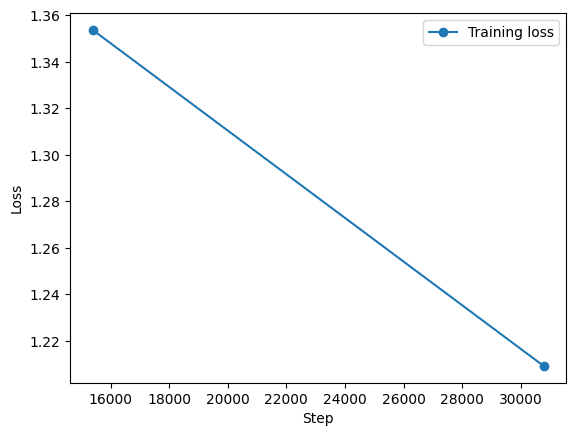

0it [00:00, ?it/s]

###########################################################################
Question: When describing gradient structures, they can be gradients in? A) dimension B) composition C) both dimension and composition
Answer: Gradient structures can be described as gradients in both dimension and composition. This means that the properties of the material change both in terms of its size or shape (dimension) and the components that make it up (composition). For example, a material with a gradient in both dimension and composition could have a varying thickness or density, as well as a changing composition of different elements or molecules.
Correct answer=C
###########################################################################
Question: What is the structure found in many crustaceans? A) Cable B) Bouligand  C) Dendritic
Answer: The correct answer is option B, Bouligand.

Bouligand structure is a type of arrangement found in many crustaceans, particularly in the exoskeletons of crabs and 

adapter_model.safetensors:   0%|          | 0.00/46.2M [00:00<?, ?B/s]

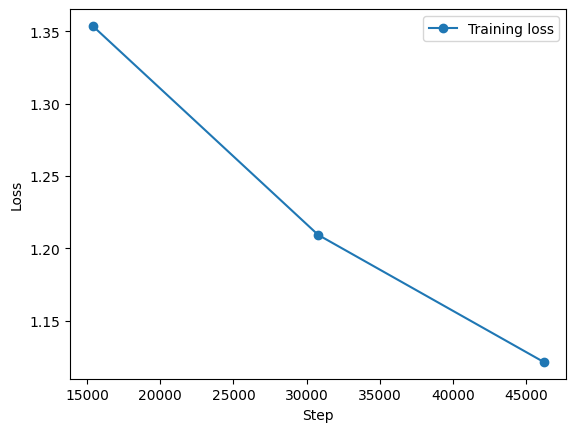

0it [00:00, ?it/s]

###########################################################################
Question: When describing gradient structures, they can be gradients in? A) dimension B) composition C) both dimension and composition
Answer: The correct answer is option C, as gradient structures can exhibit both gradients in dimension and composition. Gradient structures are characterized by a continuous variation in properties, such as thickness or composition, across a surface or material. This can result in unique properties and functions, such as enhanced mechanical strength or biocompatibility. The gradient structure can be designed to optimize specific functions, such as energy absorption or cell adhesion. The gradient structure can be found in nature, such as in the shells of mollusks, and has been mimicked in synthetic materials for various applications.
Correct answer=C
###########################################################################
Question: What is the structure found in many crustacea

adapter_model.safetensors:   0%|          | 0.00/46.2M [00:00<?, ?B/s]

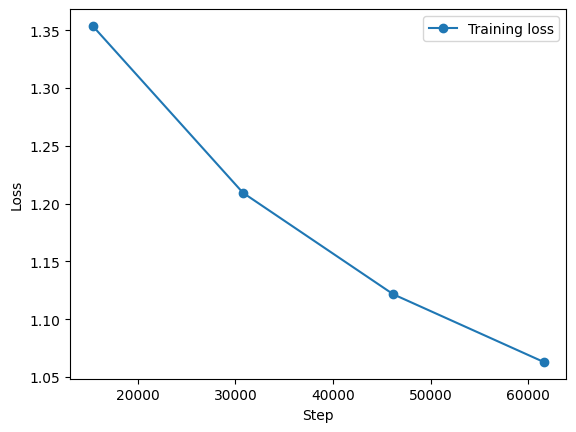

0it [00:00, ?it/s]

###########################################################################
Question: When describing gradient structures, they can be gradients in? A) dimension B) composition C) both dimension and composition
Answer: The correct answer is option C, as gradient structures can exhibit both dimensional and compositional variations. This means that the properties of the material can change gradually over a specific length scale, with variations in both the size and composition of the material. This can be observed in natural structures such as the shells of mollusks, where the thickness and composition of the shell wall vary along its length.
Correct answer=C
###########################################################################
Question: What is the structure found in many crustaceans? A) Cable B) Bouligand  C) Dendritic
Answer: The structure found in many crustaceans is Bouligand. This structure is characterized by a helicoidal arrangement of fibers, with each layer having a diffe

adapter_model.safetensors:   0%|          | 0.00/46.2M [00:00<?, ?B/s]

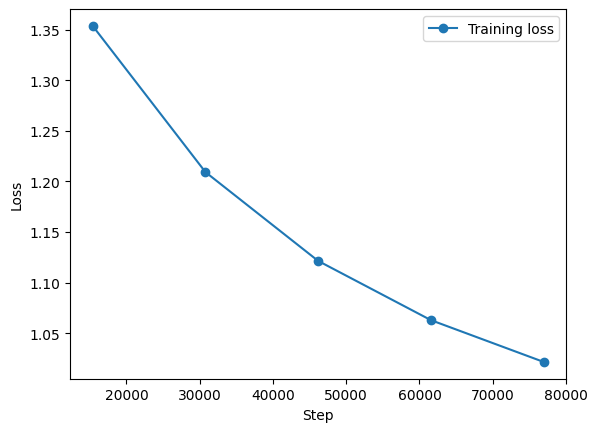

0it [00:00, ?it/s]

###########################################################################
Question: When describing gradient structures, they can be gradients in? A) dimension B) composition C) both dimension and composition
Answer: The correct answer is option C, as gradient structures can exhibit gradients in both dimension and composition. This refers to the fact that the properties of a material can vary continuously or in a stepwise manner across a surface or within a material, such as the thickness or composition of a layer. This can be observed in various natural and synthetic materials, including biological tissues and synthetic composites. The gradient structures can be designed to optimize specific properties, such as mechanical strength or thermal conductivity, by carefully controlling the composition and dimension of the layers.
Correct answer=C
###########################################################################
Question: What is the structure found in many crustaceans? A) Cable 

TrainOutput(global_step=76952, training_loss=0.8830922643952935, metrics={'train_runtime': 79859.7941, 'train_samples_per_second': 3.854, 'train_steps_per_second': 0.964, 'total_flos': 5.434857328545718e+18, 'train_loss': 0.8830922643952935, 'epoch': 5.0})

In [52]:
trainer.train(resume_from_checkpoint = f'./{FT_model_name}/tmp-checkpoint-15390//')